# Emotion Detection With Machine Learning - Data Validation
##### Algorithmic Graph Theory by Dr. Sheikhi 4022
###### Fatemeh Razaqnejad 9822123 - Baran Babaei 9931893 - Alireza DolatAbadi 9821853

Download Dataset: https://drive.google.com/file/d/1tedoFTFFBbM2iUvdg37WQFSq07ghYrll/view?usp=drive_link

### Steps to follow
1. Grouping .csv datas by emotion labels
2. Generating images from pixel values
3. Clarifying dataset by detecting faces and removing noises
4. Resizing images to the same dimentions
5. Analysis dataset
6. Plot analyses
7. Split dataset to Test and Train

### Add Libraries

In [4]:
import pandas as pd
import os
import math
import numpy as np
import base64
from PIL import Image
import io
import cv2
import matplotlib.pyplot as plt
import shutil
from sklearn.model_selection import train_test_split


##### Project Map

<img src="../screenshots/repoMap.png">

### Group Data

to group datas we first read the csv data and the group them by the first charachter of each row and save to labeled folders

In [ ]:
# load CSV file
data = pd.read_csv('../data/dataset.csv', skiprows=1)

# create destination directory
root_save_path = '../data/dataset/'
if not os.path.exists(root_save_path):
    os.makedirs(root_save_path)

# group images by lable
grouped = data.groupby(data.columns[0])

# extract and save data by in defferent directories
for label, group in grouped:
    label_save_path = os.path.join(root_save_path, str(label))
    if not os.path.exists(label_save_path):
        os.makedirs(label_save_path)
    csv_file_path = os.path.join(label_save_path, f'label_{label}.csv')
    group.to_csv(csv_file_path, header=False, index=False)


#### output screenshot

<img src="../screenshots/groupData.png">

### Generate Images

to generate images under their labels, we read the series of pixels into a list, then make a matrix with the size of list length square root using numPy and at the end we generate images and save them using image.save in *data/dataset/0/image_files* path

In [34]:
def load_data(filepath):
    """Load CSV data into a DataFrame."""
    return pd.read_csv(filepath)

for label in range(7):
    # load CSV data
    data = pd.read_csv(f'../data/dataset/{label}/label_{label}.csv', skiprows=1)

    save_path = f'../data/dataset/{label}/image_files'
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    # read dataset.csv data {lable, pixcels}
    for index, row in data.iterrows():
        pixels = row.iloc[1].split(' ')
        pixels = list(map(int, pixels))
        
        # calculate image real sizes
        image_size = int(math.sqrt(len(pixels)))
        image_array = np.array(pixels, dtype=np.uint8).reshape((image_size, image_size))
        
        # creat image and save
        image = Image.fromarray(image_array)
        image.save(os.path.join(save_path, f'label_{label}_index_{index}.png'))

#### output screenshot

<img src="../screenshots/generateImages.png">

### Clarify Dataset

this part is a bit tricky, to clarify images we need to follow these steps:
1. loading face detection model
2. gray scale images
3. detecting faces on each image
4. if there was any faces, calculate the area of detected face and total image
5. calculating percentage of face on the image
6. crop the image and keep only the faces
7. add the clarity percentage to the file names and save to the *data/dataset/0/validated_images*
8. if there was no face, we take the image as *noise8 and increse the nois numbers

In [ ]:
def calculate_clarity(image_path, save_path, face_cascade):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Convert to grayscale for face detection

    # Detect faces in the image
    faces = face_cascade.detectMultiScale(image, scaleFactor=1.1, minNeighbors=0)

    if len(faces) > 0:
        # Assuming only one face is detected (but we can modify this for multiple faces)
        x, y, w, h = faces[0]

        # Calculate face area and total image area
        face_area = w * h
        total_image_area = image.shape[0] * image.shape[1]

        # Calculate noise percentage
        clarity_percentage = (face_area / total_image_area) * 100

        # Crop the image to keep only the detected face region
        face_image = image[y:y+h, x:x+w]

        # Add clarity percentage to the image file name
        new_filename = f"{filename.split('.')[0]}_{clarity_percentage:.2f}.png"
        new_image_path = os.path.join(save_path, new_filename)
        cv2.imwrite(new_image_path, face_image)  # Save the cropped face image
        os.remove(image_path)  # Remove the original image

        #print(f"Renamed and cropped: {filename} -> {new_filename}")
        return 0
    else:
        #print(f"No face detected in {filename}")
        return 1

# Load the face detection model (OpenCV's Haarcascades or a deep learning-based model)
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
noise_number=[]
# Assuming you have already loaded the images
for label in range(7):
    noise_number.append(0)
    image_folder = f'../data/dataset/{label}/image_files'
    save_path = f'../data/dataset/{label}/validated_images'
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    for filename in os.listdir(image_folder):
        if filename.endswith(".png"):
            image_path = os.path.join(image_folder, filename)
            noise_number[label]+=calculate_clarity(image_path, save_path, face_cascade)
    print(f'{noise_number[label]} detected for group {label}')
print("Clarity sets for the datas succesfully")

#### output screenshot

<img src="../screenshots/noiseDetection.png">

### Resize Images

as some images had croped in the privious step, we need to resize all the dataset to the same image size and we do it using cv2.resize and replace the original images

In [36]:
# Define a function to resize images to 128x128
def resize_images_in_place(folder_path, size=(128, 128)):
    for image_name in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image_name)
        
        # Read images ans resize
        image = cv2.imread(image_path)
        resized_image = cv2.resize(image, size, interpolation=cv2.INTER_AREA)
        
        # Replace original images with the resized ones
        cv2.imwrite(image_path, resized_image)

for label in range(7):
    # Define the source and destination image folder paths
    folder_path = f'../data/dataset/{label}/validated_images'
    resize_images_in_place(folder_path)

# Print a success message
print("Images have been succesfully resized and saved to the new path.")

Images have been succesfully resized and saved to the new path.


### Analyze Dataset

first we initialize a dictionary to keep analysed datas. then we just have to walk trouhj all the folders and count datas. noticeably we've already calculated noise per class on the clarification step.

In [44]:
# Define the base path for the dataset
base_path = '../data/dataset'

# Initialize statistics dictionary
statistics = {
    'total_images': 0,
    'images_per_class': {},
    'noise_per_class': {}
}

# Gather statistics
for class_folder in os.listdir(base_path):
    class_path = os.path.join(base_path, class_folder)
    validated_images_path = os.path.join(class_path, 'validated_images')
    
    # Skip if not a directory
    if not os.path.isdir(validated_images_path):
        continue
    
    # Initialize class statistics
    statistics['images_per_class'][class_folder] = 0
    
    # Iterate over images in each class
    for image_name in os.listdir(validated_images_path):
        image_path = os.path.join(validated_images_path, image_name)
        
        # Update total images count
        statistics['total_images'] += 1
        
        # Update images per class count
        statistics['images_per_class'][class_folder] += 1
        
    statistics['noise_per_class'][class_folder] = noise_number[int(class_folder)] / statistics['images_per_class'][class_folder] * 100


# Print the gathered statistics
print(f"Total number of images: {statistics['total_images']}")
for class_folder, count in statistics['images_per_class'].items():
    print(f"Number of images in class {class_folder}: {count}")
    print(f"Noise images in class {class_folder}: {statistics['noise_per_class'][class_folder]:.2f}")

# Print the distribution of classes
print("Distribution of classes:")
for class_folder, count in statistics['images_per_class'].items():
    distribution = (count / statistics['total_images']) * 100
    print(f"Class {class_folder}: {distribution:.2f}%")

Total number of images: 23620
Number of images in class 0: 3211
Noise images in class 0: 54.16
Number of images in class 1: 348
Noise images in class 1: 56.61
Number of images in class 2: 3090
Noise images in class 2: 65.66
Number of images in class 3: 6330
Noise images in class 3: 41.97
Number of images in class 4: 3215
Noise images in class 4: 88.96
Number of images in class 5: 2863
Noise images in class 5: 39.71
Number of images in class 6: 4563
Noise images in class 6: 35.79
Distribution of classes:
Class 0: 13.59%
Class 1: 1.47%
Class 2: 13.08%
Class 3: 26.80%
Class 4: 13.61%
Class 5: 12.12%
Class 6: 19.32%


#### output screenshot

<img src="../screenshots/analysis.png">

### Plot Analyses

now we first initialize a dictionary for emotion labels, and the plot the values we calculated in the analysing step.

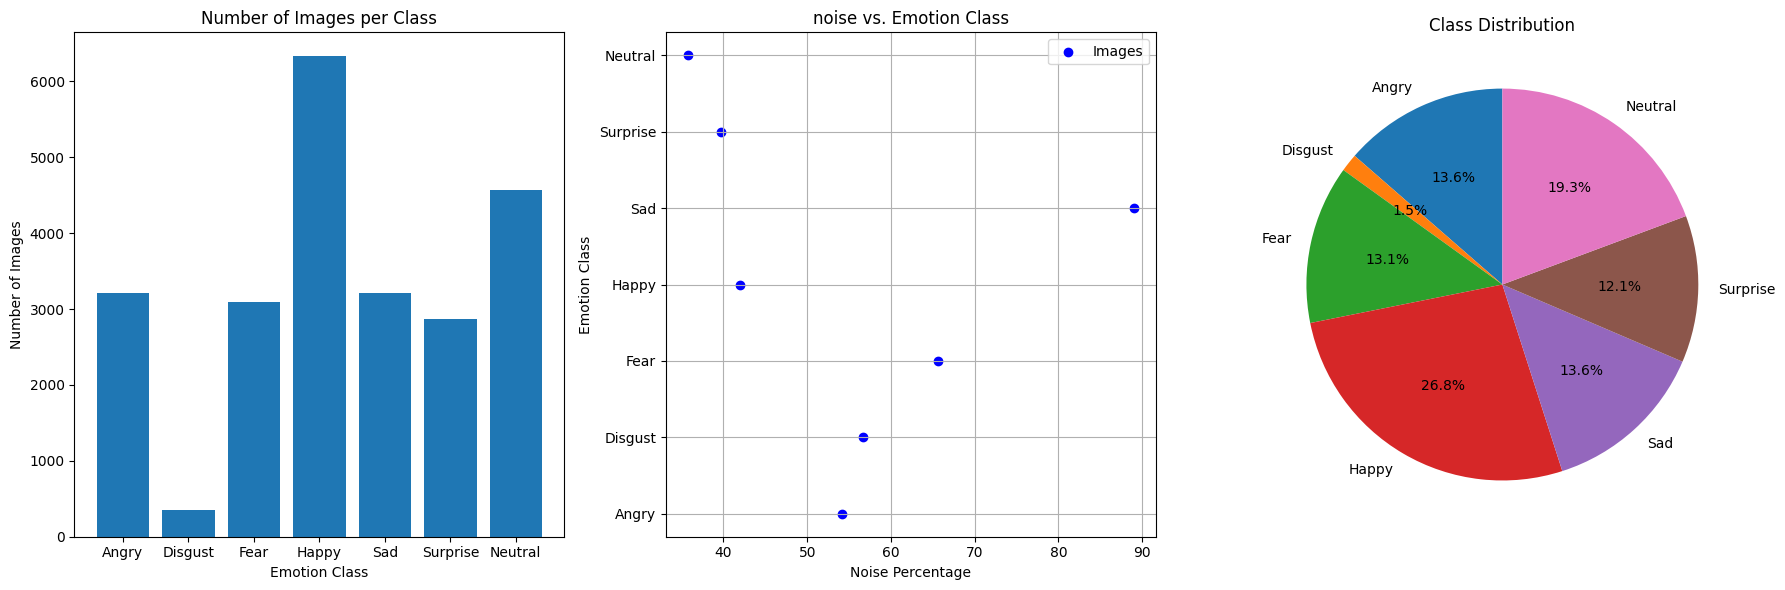

In [48]:
# Data for plotting
class_names = list(statistics['images_per_class'].keys())
image_counts = list(statistics['images_per_class'].values())
noise_percentage = list(statistics['noise_per_class'].values())

# Create a dictionary to map class numbers to class names
class_mapping = {
    '0': 'Angry',
    '1': 'Disgust',
    '2': 'Fear',
    '3': 'Happy',
    '4': 'Sad',
    '5': 'Surprise',
    '6': 'Neutral'
}

# Replace numeric class labels with class names
class_names_display = [class_mapping[class_name] for class_name in class_names]

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Bar plot: Number of images per class
axs[0].bar(class_names_display, image_counts)
axs[0].set_title('Number of Images per Class')
axs[0].set_xlabel('Emotion Class')
axs[0].set_ylabel('Number of Images')

# Scatter plot: noise vs. Emotion Class
axs[1].scatter(noise_percentage, class_names_display, color='b', marker='o', label='Images')
axs[1].set_xlabel('Noise Percentage')
axs[1].set_ylabel('Emotion Class')
axs[1].set_title('noise vs. Emotion Class')
axs[1].grid(True)
axs[1].legend()

# The rest of the code remains unchanged.


# Pie chart: Class distribution
axs[2].pie(image_counts, labels=class_names_display, autopct='%1.1f%%', startangle=90)
axs[2].set_title('Class Distribution')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

* as you can see we have the **biggest** dataset with 6330 images for emotion **Happy** and the **smallest** dataset with 348 images for emotion **Disgust**
* also we have the **most** noises for emotion **Sad** with the value of 88.96 and the **least** noises for emotion **Neutreal**

### Split Test And Train

at the end, to split dataset into train and test, we use sklearn library following these steps:
1. listing all the pathes and labels to walk randomly through them
2. split %20 of data to test and %80 of data to train lists
3. copy the images into *data/test* and *data/train*

In [49]:
# Define the base path for the dataset
base_path = '../data'

# Lists to store file paths and labels
file_paths = []
labels = []

# Collect file paths and labels
for label in range(7):
    class_path = os.path.join(base_path, 'dataset', str(label), 'validated_images')
    for image_name in os.listdir(class_path):
        file_paths.append(os.path.join(class_path, image_name))
        labels.append(label)

# Convert lists to arrays
X = np.array(file_paths)
y = np.array(labels)

# Split the data into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define directories for saving training and testing images
train_dir = os.path.join(base_path, 'train')
test_dir = os.path.join(base_path, 'test')

# Create directories if they don't exist
if not os.path.exists(train_dir):
    os.makedirs(train_dir)
if not os.path.exists(test_dir):
    os.makedirs(test_dir)

# Function to copy files to the new directories
def copy_files(file_paths, labels, destination_dir):
    for i, file_path in enumerate(file_paths):
        # Create subdirectories for each label if they don't exist
        label_dir = os.path.join(destination_dir, str(labels[i]))
        if not os.path.exists(label_dir):
            os.makedirs(label_dir)
        
        # Copy the file to the new directory
        shutil.copy(file_path, label_dir)
        #print(f"File {os.path.basename(file_path)} copied to {label_dir}.")

# Copy training and testing images to the respective directories
copy_files(X_train, y_train, train_dir)
copy_files(X_test, y_test, test_dir)

# Print a success message
print("Images have been successfully split into training and testing subsets and saved in the corresponding directories.")


Images have been successfully split into training and testing subsets and saved in the corresponding directories.


#### output screenshot

<img src="../screenshots/split.png">

## Conclusion Of ML/DL Papers

#### **Conventional Machine Learning Methods in FER**

**Machine Learning in Facial Emotion Recognition:**
- Conventional ML methods involve explicit feature extraction followed by classification.
- These methods are often simpler and more interpretable compared to deep learning models.

**Key Techniques:**
- **Principal Component Analysis (PCA)**: Used for dimensionality reduction to enhance computational efficiency by simplifying the data without losing significant information.
- **Support Vector Machines (SVM)**: Effective for classification tasks, works well on smaller, cleaner datasets and can efficiently model complex emotional boundaries.
- **Random Forest and Decision Trees**: Robust to overfitting and provide good accuracy by combining the decisions of multiple trees.

**Strengths and Limitations:**
- **Strengths**: Easier to implement, require less computational resources, and offer good interpretability.
- **Limitations**: Limited by the need for hand-engineered features and may not perform well on very large or complex datasets.

#### **Conventional Deep Learning Methods in FER**

**Deep Learning in Facial Emotion Recognition:**
- Deep learning automates feature extraction and can learn high-level abstractions, suitable for complex facial expression analysis.

**Advanced Techniques:**
- **Convolutional Neural Networks (CNNs)**: Specializes in picking up spatial hierarchies in image data using trainable filters and pooling layers, ideal for capturing subtle facial cues.
- **Recurrent Neural Networks (RNNs)**: Useful for dynamic expression recognition where temporal dependencies exist.

**Performance and Applications:**
- **Accuracy**: Generally, DL models outperform ML models in terms of accuracy on larger and more diverse datasets.
- **Real-Time Capability**: Increasingly used in real-time FER systems in security and interactive entertainment due to their ability to operate on raw data.

#### **Comparative Analysis of ML and DL Methods**

**Performance Comparison:**
- Discuss specific case studies or findings from the reviewed papers that compare ML and DL, highlighting instances where one significantly outperforms the other.
- General trends include DL models' superior performance in complex scenarios involving unstructured data.

**Hybrid Approaches:**
- Concept of combining ML and DL models to leverage strengths of both: ML for speed and simplicity, DL for robustness and higher accuracy.
- Examples include using ML techniques for initial coarse filtering followed by DL for fine-grained analysis.

**Choosing Between ML and DL:**
- Decision factors include dataset size and quality, need for real-time processing, computational resources, and specific application requirements.
- Choice often depends on the trade-off between accuracy and computational efficiency, as well as availability of training data and labels.
